## Imports

In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.interpolate import BSpline
import numpy as np


import jax
import jax.numpy as jnp
from jax.lax.linalg import tridiagonal_solve
from jax.scipy.interpolate import RegularGridInterpolator
import optax

from utils import make_spline, num_grid, num_uptake, an_grid, an_uptake, L2norm, accurate_num_uptake

from collections.abc import Callable, Iterable
from typing import Optional
import itertools

import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\willi\\Documents\\Diffusion-Modeling\\utils.py'>

## Importing Experimental Uptake Data

In [9]:
data_dir = "./data/DopantUptake/DopantUptake/Data"
samples = [os.path.join(data_dir, sample) for sample in os.listdir(data_dir)]


sample_dfs = {}
for sample in samples:
    sample_name = os.path.basename(sample).split('.')[0]
    sample_dfs[sample_name] = pd.read_csv(sample, sep='\t', skiprows=1, na_values=["Failed"])

def sorter(item):
    if item[0].startswith('Sample'):
        return int(item[0].split(' ')[-1])
    else: return 0

sample_dfs = dict( sorted(sample_dfs.items(), key=sorter) )

In [10]:
# Import thicknesses
thicknesses = pd.read_excel('./data/DopantUptake/DopantUptake/QCMSummary.xlsx', sheet_name='Thicknesses', index_col='Sample')
thicknesses

,Thickness [A]
Sample,
2,233.00000
15,205.75000
21,237.50000
22,282.25000
24,304.25000
39,257.00000
50,290.25000
53,234.50000
58,321.50000


In [3]:
sample_dfs.keys()

dict_keys(['Reference_bare sensor 1', 'Reference_bare sensor 2', 'Reference_bare sensor 3', 'Sample 1', 'Sample 2', 'Sample 3', 'Sample 12', 'Sample 15', 'Sample 21', 'Sample 22', 'Sample 23', 'Sample 24', 'Sample 39', 'Sample 50', 'Sample 53', 'Sample 58', 'Sample 61', 'Sample 80', 'Sample 81'])

In [4]:
sample_dfs['Sample 12']

,Time [s],R2_m9 [ng/cm^2],C1_m [ng/cm^2]
0,0.0000,NaN,NaN
1,1.3259,NaN,NaN
2,2.6424,NaN,NaN
3,3.9720,NaN,NaN
4,5.3007,NaN,NaN
...,...,...,...
4395,1764.2580,749.44,749.82
4396,1764.6506,754.17,751.57
4397,1765.0690,752.55,749.63
4398,1765.5342,751.58,750.93


## Plotting Experimental Uptake Data

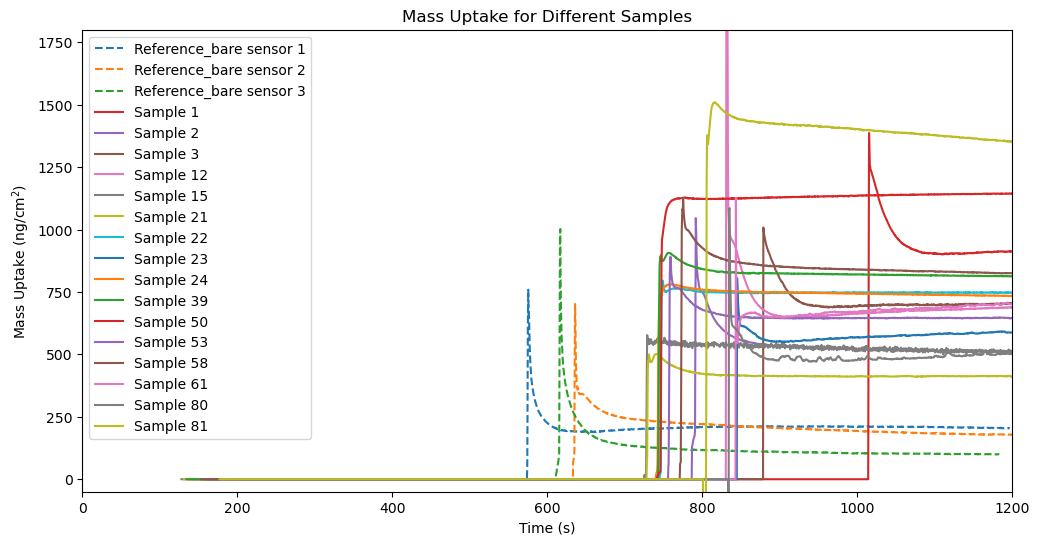

In [23]:
plt.figure(figsize=(12, 6))
plt.title('Mass Uptake for Different Samples')
plt.xlabel('Time (s)')
plt.ylabel('Mass Uptake (ng/cm$^2$)')

for sample_name in sample_dfs:
    if sample_name.startswith('Sample'): linestyle = '-'
    else: linestyle = '--'
    t = sample_dfs[sample_name]['Time [s]']
    m = sample_dfs[sample_name]['C1_m [ng/cm^2]']
    plt.plot(t, m, label=sample_name, linestyle=linestyle)


plt.xlim(0, 1200)
plt.ylim(-50, 1800)
plt.legend()

## Isolating Uptakes

### Grouped by highest dm/dt

In [ ]:
cropped_sample_dfs_highest = {}
df_list = []

for sample_name in sample_dfs:

    sample_df = sample_dfs[sample_name]
    sample_df = sample_df.dropna()

    # Find middle of uptake
    t = sample_df['Time [s]']
    m = sample_df['C1_m [ng/cm^2]']

    sample_df['dm/dt'] = jnp.gradient(m, t)

    idx_max = int( sample_df['dm/dt'].idxmax() )

    df_cropped = sample_df.loc[(idx_max-5):(idx_max+10)]

    t0 = df_cropped.loc[idx_max, 'Time [s]']
    df_cropped['Time shifted [s]'] = df_cropped['Time [s]'] - t0

    df_cropped = df_cropped.reset_index(drop=True)
    
    # Set up this part of the combined df
    temp = df_cropped[['Time shifted [s]', 'C1_m [ng/cm^2]']].copy()
    temp = temp.rename(columns={'C1_m [ng/cm^2]': sample_name})
    temp = temp.set_index('Time shifted [s]')
    df_list.append(temp)

    # Add cropped sample df to dict
    cropped_sample_dfs_highest[sample_name] = df_cropped

merged_df = pd.concat(df_list, axis=1) # concatenate all along columns, automatically aligns on index/time. If no data for that time in a given column, NaN entered.
merged_df = merged_df.sort_index()
merged_df = merged_df.groupby(merged_df.index).first() # Remove duplicate times/associated NaNs

C:\Users\willi\AppData\Local\Temp\ipykernel_3116\1101613382.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['dm/dt'] = np.gradient(m, t)
C:\Users\willi\AppData\Local\Temp\ipykernel_3116\1101613382.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cropped['Time shifted [s]'] = df_cropped['Time [s]'] - t0
C:\Users\willi\AppData\Local\Temp\ipykernel_3116\1101613382.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [44]:
merged_df

,Reference_bare sensor 1,Reference_bare sensor 2,Reference_bare sensor 3,Sample 1,Sample 2,Sample 3,Sample 12,Sample 15,Sample 21,Sample 22,Sample 23,Sample 24,Sample 39,Sample 50,Sample 53,Sample 58,Sample 61,Sample 80,Sample 81
Time shifted [s],,,,,,,,,,,,,,,,,,,
-3.0976,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2.6948,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2.5440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2.4190,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2.3158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.7699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780.09,NaN,NaN,NaN,NaN
4.7950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,613.09,NaN
4.8216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1043.66,NaN,NaN,NaN,NaN,NaN


In [39]:
# Check

for col in list(merged_df.columns):
    print(merged_df[col].count())

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


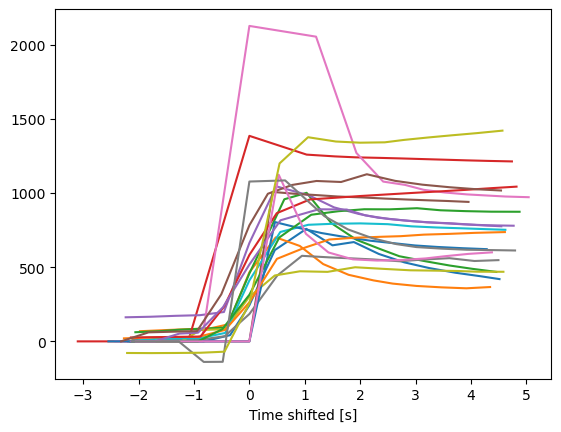

In [50]:
for col in list(merged_df.columns):
    merged_df[col].dropna().plot()

In [ ]:
cropped_sample_dfs_highest.keys()

dict_keys(['Reference_bare sensor 1', 'Reference_bare sensor 2', 'Reference_bare sensor 3', 'Sample 1', 'Sample 2', 'Sample 3', 'Sample 12', 'Sample 15', 'Sample 21', 'Sample 22', 'Sample 23', 'Sample 24', 'Sample 39', 'Sample 50', 'Sample 53', 'Sample 58', 'Sample 61', 'Sample 80', 'Sample 81'])

In [ ]:
len(cropped_sample_dfs_highest)

19

In [ ]:
cropped_sample_dfs_highest['Sample 2']

,Time [s],R1_m5 [ng/cm^2],C1_m [ng/cm^2],dm/dt,Time shifted [s]
0,788.7621,159.89,162.43,10.573461,-2.2330
1,789.2139,165.75,166.18,11.000616,-1.7812
2,789.6663,172.60,172.38,11.775053,-1.3288
3,790.1044,176.80,176.72,29.940592,-0.8907
4,790.5357,182.49,198.14,516.270839,-0.4594
5,790.9951,592.01,663.64,903.325806,0.0000
6,791.4806,1060.09,1045.79,385.726374,0.4855
7,792.0720,1007.71,984.74,-146.321361,1.0769
8,792.5237,923.96,903.78,-139.038109,1.5286
9,792.9692,876.88,859.50,-84.628283,1.9741


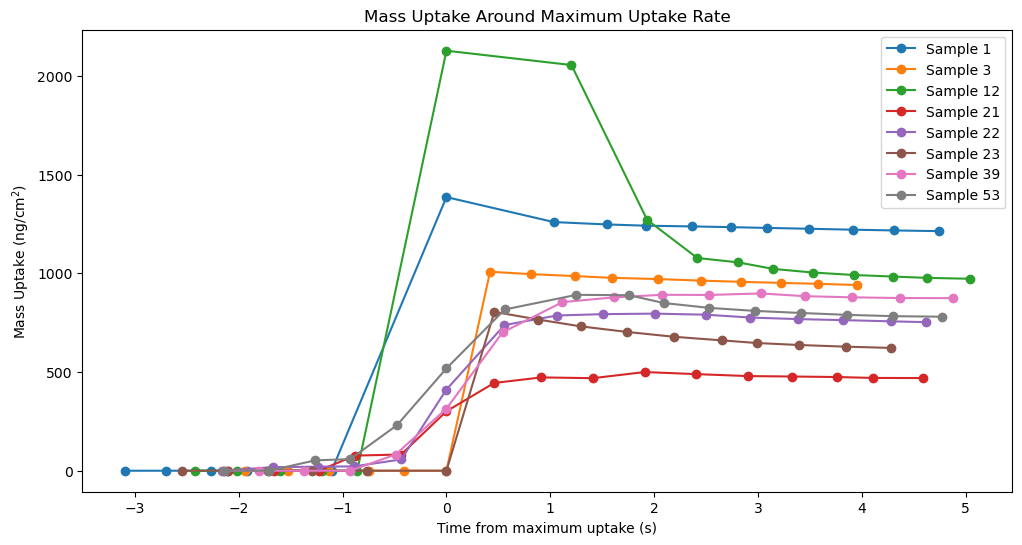

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Mass Uptake Around Maximum Uptake Rate')
plt.xlabel('Time from maximum uptake (s)')
plt.ylabel('Mass Uptake (ng/cm$^2$)')

for sample_name in list(cropped_sample_dfs_highest.keys())[:15]:
    if sample_name.startswith('Sample'): 
        df_cropped = cropped_sample_dfs_highest[sample_name]
        if df_cropped.loc[0,'m'] < 1:
            plt.plot(df_cropped['t shifted'], df_cropped['m'], marker='o', linestyle='-', label=sample_name)

plt.legend()

### Grouped by initial uptake

In [11]:
cropped_sample_dfs_first = {}

for sample_name in sample_dfs:

    sample_df = sample_dfs[sample_name]
    sample_df = sample_df.dropna()


    idx_first = sample_df.loc[sample_df['C1_m [ng/cm^2]'] != 0].index[0] # Isolates the first nonzero uptake


    df_cropped = sample_df.loc[(idx_first-5):(idx_first+15)]

    t0 = df_cropped.loc[idx_first-1, 'Time [s]']  # Make t=0 the first point BEFORE any uptake is detected
    df_cropped['Time shifted [s]'] = df_cropped['Time [s]'] - t0

    df_cropped = df_cropped.reset_index(drop=True)
    

    cropped_sample_dfs_first[sample_name] = df_cropped
    

C:\Users\willi\AppData\Local\Temp\ipykernel_28804\709114923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cropped['Time shifted [s]'] = df_cropped['Time [s]'] - t0
C:\Users\willi\AppData\Local\Temp\ipykernel_28804\709114923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cropped['Time shifted [s]'] = df_cropped['Time [s]'] - t0
C:\Users\willi\AppData\Local\Temp\ipykernel_28804\709114923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [111]:
cropped_sample_dfs_first.keys()

dict_keys(['Reference_bare sensor 1', 'Reference_bare sensor 2', 'Reference_bare sensor 3', 'Sample 1', 'Sample 2', 'Sample 3', 'Sample 12', 'Sample 15', 'Sample 21', 'Sample 22', 'Sample 23', 'Sample 24', 'Sample 39', 'Sample 50', 'Sample 53', 'Sample 58', 'Sample 61', 'Sample 80', 'Sample 81'])

In [112]:
cropped_sample_dfs_first['Sample 2']

,Time [s],R1_m5 [ng/cm^2],C1_m [ng/cm^2],Time shifted [s]
0,784.4969,0.00,0.00,-1.7137
1,784.8411,0.00,0.00,-1.3695
2,785.2929,0.00,0.00,-0.9177
3,785.7706,0.00,0.00,-0.4400
4,786.2106,0.00,0.00,0.0000
5,786.6689,129.86,130.02,0.4583
6,787.0951,135.30,136.08,0.8845
7,787.5232,146.60,144.26,1.3126
8,787.9684,151.61,151.42,1.7578
9,788.3119,156.44,156.65,2.1013


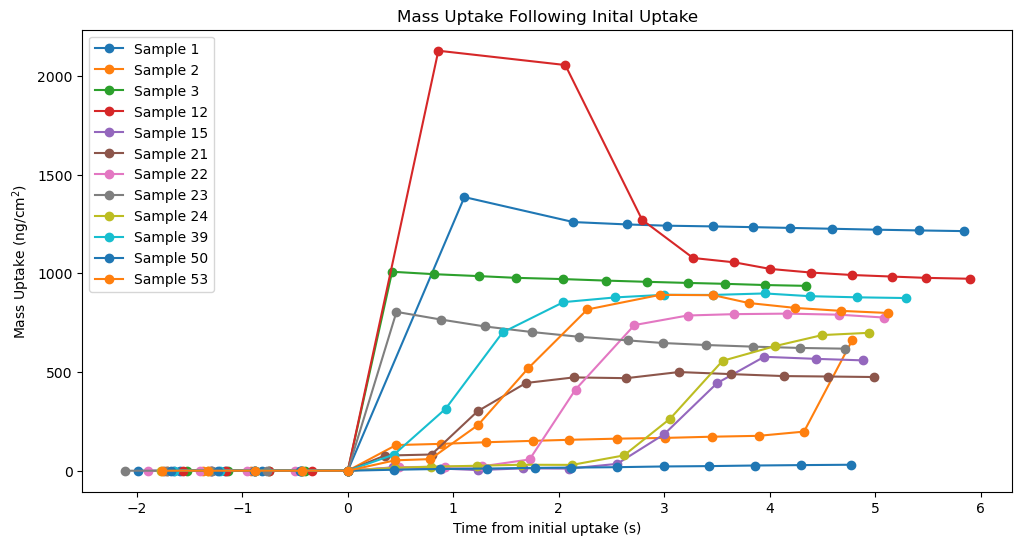

In [113]:
plt.figure(figsize=(12, 6))
plt.title('Mass Uptake Following Inital Uptake')
plt.xlabel('Time from initial uptake (s)')
plt.ylabel('Mass Uptake (ng/cm$^2$)')

for sample_name in list(cropped_sample_dfs_first.keys())[:15]:
    if sample_name.startswith('Sample'): 
        df_cropped = cropped_sample_dfs_first[sample_name]
        if df_cropped.loc[0,'C1_m [ng/cm^2]'] < 1:
            plt.plot(df_cropped['Time shifted [s]'], df_cropped['C1_m [ng/cm^2]'], marker='o', linestyle='-', label=sample_name)

plt.legend()

## Analytic Solution for Given Boundary Conditions

### Background

$$
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2}
$$
#### Boundary Conditions

**Top (x=0):**

 - Inhomogeneous Dirichlet

 - $C(0, t) = C_0$

 - Drop on polymer surface provides effectively constant concentration at the top boundary.

**Bottom (x=L):**

 - Neumann

 - $\frac{\partial C}{\partial x} \left(L, t \right) = 0$

 - Gold cathode on top of the quartz prevents flux through the lower boundary of the polymer.

  #### Initial Conditions

 - $C(x, t_0) = 0 $

 #### Shifted Solution

 To recover homogeneous boundary conditions, shift the solution by $C_0$ (i.e., a function that obeys the boundary conditions, $w(x,t) = C_0$).

 $$
 u(x,t) = C(x,t) - C_0
 $$

 #### Separation of Variables

 $$
 
 u(x, t) = X(x)T(t)

 \\[1em]

 X(x)T'(t) = D X''(x)T(t)

 \\[1em]

 \frac{T'}{DT} = \frac{X''}{X} \equiv -\lambda

 \\[1em]

 T'(t) + D \lambda T(t) = 0, \qquad X''(x) + \lambda X(x) = 0

 $$

 #### Spatial Eigenvalue Problem

 $$
 X'' + \lambda X = 0
 $$

 **Solution:**

 $$
 X(x) = A \sin(\sqrt{\lambda}x) + B \cos(\sqrt{\lambda} x)
 $$

 Apply boundary conditions to solve for A and B. 

 **Top (Dirichlet Condition):** 

 $$
 X(0) = 0 \rightarrow B = 0
 $$

**Bottom (Neumann Condition):**

$$

X'(x) = A\sqrt{\lambda} \cos(\sqrt{\lambda} x)

\\[1em]

X'(L) = cos(\sqrt{\lambda} L) 

\\[1em]

cos(\sqrt{\lambda} L) = 0

\\[1em]

\sqrt{\lambda} L = (m+1/2)\pi, \qquad m = 0, 1, 2,...

$$

#### Time ODE

$$
T'_m (t) + D \lambda_m T_m(t) = 0
$$

**Solutions:**

$$
T_m(t) = e^{-D \lambda_m t}
$$

#### General Solution

$$

u(x, t) = \sum_{m=0}^\infty a_m \sin(\sqrt{\lambda_m}x) e^{-D \lambda_m t}

\\[1em]

C(x, t) = C_0 + \sum_{m=0}^\infty a_m \sin(\sqrt{\lambda_m}x) e^{-D \lambda_m t}

\\[1em]

\lambda_m = \left( \frac{(m+1/2)\pi}{L} \right)^2

\\[1em]

a_m = \frac{2}{L} \int_0^L (C(x,t_0) - C_0) \sin(\sqrt{\lambda_m} x) dx

\\[1em]

a_m = \frac{-2C_0}{L} \int_0^L \sin(\sqrt{\lambda_m} x) dx

\\[1em]

a_m = \frac{-2C_0 }{L \sqrt{\lambda_m}} 
$$

### Testing

In [2]:
C0 = 5
D = 0.5
L = 1
tf = 5



C = an_grid(C0, D, L, tf)

C

c:\Users\willi\Documents\Diffusion-Modeling\utils.py:302: UserWarning: Explicitly requested dtype float64 requested in full is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  C = jnp.full((Nt, Nx), C0, dtype='float')


Array([[ 5.0000000e+00, -8.9487898e-01,  4.8584715e-01, ...,
         3.1904287e-03, -3.1832950e-03,  3.1832480e-03],
       [ 5.0000000e+00,  4.9201369e+00,  4.8403053e+00, ...,
         1.9712184e-07, -2.8688751e-08,  1.3370733e-07],
       [ 5.0000000e+00,  4.9435263e+00,  4.8870640e+00, ...,
        -2.0794666e-07, -6.1264025e-08,  1.0766376e-07],
       ...,
       [ 5.0000000e+00,  4.9999571e+00,  4.9999142e+00, ...,
         4.9863334e+00,  4.9863334e+00,  4.9863329e+00],
       [ 5.0000000e+00,  4.9999576e+00,  4.9999151e+00, ...,
         4.9865012e+00,  4.9865012e+00,  4.9865012e+00],
       [ 5.0000000e+00,  4.9999580e+00,  4.9999161e+00, ...,
         4.9866672e+00,  4.9866667e+00,  4.9866667e+00]], dtype=float32)

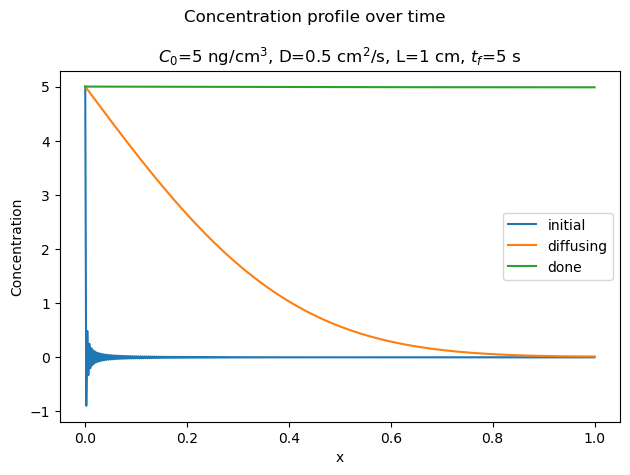

Total Solute:
t=0.00s: 0.0088
t=0.20s: 1.7876
t=2.50s: 4.8157
t=5.00s: 4.9915


In [3]:
L = 1
tf = 5


x = jnp.linspace(0, L, C.shape[1])
dx = L/C.shape[1]
dt = tf/C.shape[0]

plt.plot(x, C[0], label='initial')
plt.plot(x, C[10], label = 'diffusing')
plt.plot(x, C[-1], label='done')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.suptitle(f"Concentration profile over time")
plt.title("$C_0$=5 ng/cm$^3$, D=0.5 cm$^2$/s, L=1 cm, $t_f$=5 s")
plt.legend()
plt.tight_layout()
plt.show()

print("Total Solute:")
print(f't=0.00s: {jnp.sum(C[0]*dx):.4f}')
print(f't={20*dt:.2f}s: {jnp.sum(C[20]*dx):.4f}')
print(f't={250*dt:.2f}s: {jnp.sum(C[250]*dx):.4f}')
print(f't=5.00s: {jnp.sum(C[-1]*dx):.4f}')

  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\willi\Documents\Diffusion-Modeling\utils.py:329: UserWarning: Explicitly requested dtype float64 requested in full is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  C = jnp.full(Nx, C0, dtype='float')
100%|██████████| 500/500 [00:32<00:00, 15.26it/s]


Text(0.5, 1.0, 'Mass Uptake over Time')

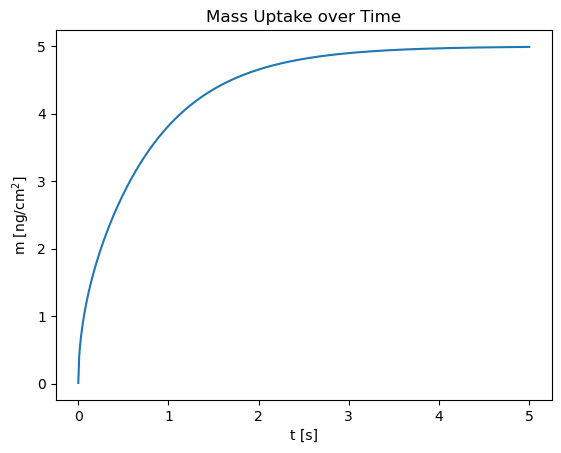

In [4]:
C0 = 5
D = 0.5
L = 1
times = jnp.linspace(0, 5, 500)

uptake_data = an_uptake(C0, D, L, times)

plt.plot(times, uptake_data)
plt.xlabel('t [s]')
plt.ylabel('m [ng/cm$^2$]')
plt.title('Mass Uptake over Time')

As expected, mass uptake asymptotically approaches the maximum possible uptake, $C_0 \cdot L$. This is because the highest concentration profile possible is the steady state profile $C(x,t)=C_0$.

## Initial Conditions and Units

### Initial Conditions from Slides

*Assuming constant-D simple diffusion*, the uptake curve depends on three parameters:

- **Concentration of Solvent Drop:** From slides: "Loaded solution (50 μL, 2 mg/mL) is added to the existing solvent to introduce dopant which results in mass uptake in the film which we model with the Sauerbrey formula". Thus, $$C_{dopant} = 2 \text{ mg/mL} = 2 \text{ mg/cm}^3 = 2 \times 10^3 \text{ ng/cm}^3$$ 

- **Boundary concentration (C0):** A simple calculation shows that using the dopant concentration as $C_0$ produces far too small of a final uptake. This suggests that mass uptake is dominated by solvent diffusion into the film. Thus, the density of the solvent is used as the effective boundary concentration in units mass per unit volume.

    - The final steady-state uptake of the samples shows that solvent density is somewhat less than the density of water, $C_0 = 1 \text{ g/mL} = 1 \times 10^9 \text{ ng/cm}^3$. $$m_f = L \cdot C_0 \rightarrow C_0 = m_f/L$$
 
    - Because the units for $L$ [$\text{cm}$] and $t$ [$\text{s}$] cancel with the units of $D$ [$\text{cm}^2/\text{s}$], any units for concentration can be used.


- **Diffusion Coefficient (D):** This is the independant variable that must be determined via fitting. Measured in $\text{cm}^2/\text{s}$.

    - Values on the order of $10^{-12} \text{ cm}^2/\text{s}$ seem to be appropriate

- **Film Thickness (L):** Given per film in $[\text{\AA} = 10^{-8} \text{ cm}$ inside `QCMSummary.xlsx`.

### Units of Mass Uptake

- Measured in $\text{ng}/\text{cm}^2$ in the `.csv` files. 

- Calculated from $m(t) = \int{C(x, t) dx}$.

- Thus, we need initial concentration $C_0$ in $\text{ng/cm}^3$.


## Plotting Analytic Uptake Curves

### Importing Thicknesses

In [4]:
thicknesses = pd.read_excel('./data/DopantUptake/DopantUptake/QCMSummary.xlsx', sheet_name='Thicknesses', index_col='Sample')

thicknesses

,Thickness [A]
Sample,
2,233.00000
15,205.75000
21,237.50000
22,282.25000
24,304.25000
39,257.00000
50,290.25000
53,234.50000
58,321.50000


### Sample 53

In [5]:
df = cropped_sample_dfs_first['Sample 53']

df = df[df['Time shifted [s]'] >= 0]

df

,Time [s],R1_m5 [ng/cm^2],C1_m [ng/cm^2],Time shifted [s]
4,755.6474,0.00,0.00,0.0000
5,756.0940,54.55,52.60,0.4466
6,756.4296,59.52,58.80,0.7822
7,756.8808,170.48,230.82,1.2334
8,757.3564,474.46,518.39,1.7090
9,757.9181,848.96,816.87,2.2707
10,758.6082,900.21,890.98,2.9608
11,759.1141,898.65,889.12,3.4667
12,759.4475,852.03,849.68,3.8001
13,759.8885,827.10,824.80,4.2411


### Finding an Appropriate C0, D

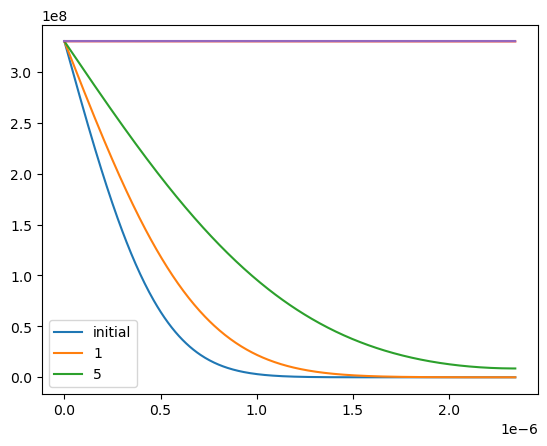

In [43]:
# Test plot

times = df['Time shifted [s]'] # [s]
m_exp = df['C1_m [ng/cm^2]']   # [ng/cm^2]


L_A = thicknesses.loc[53, 'Thickness [A]'] # [A]
L = L_A*1e-8 # [cm]

# Divide final uptake (assuming steady state reached) by the length to get assumed boundary concentration
C0 = m_exp.iloc[-1]/L # [ng/cm^3]

D = 5e-12 # [cm^2/s]

Nx = 500

tf = times.iloc[-1]

an_soln = an_grid(C0, D, L, tf, Nx=Nx)


x = np.linspace(0, L, Nx+1)

plt.plot(x, an_soln[0], label = 'initial')

plt.plot(x, an_soln[1], label = '1')

plt.plot(x, an_soln[5], label='5')

plt.plot(x, an_soln[250])

plt.plot(x, an_soln[-1])

plt.legend()


In [8]:
print(f'Assumed boundary concentration: {C0:.2e} ng/cm^3')

# this is likely the density of the solvent
# Density of water is 1e9 ng/cm3

Assumed boundary concentration: 3.30e+08 ng/cm^3


### Plotting Uptake Curves for Different Values of Constant D

In [41]:
m_an = {}
k=0
f = lambda x: jnp.ones_like(x)*D

for D in np.linspace(1e-15, 1e-12, 100):
    m_an[D] = num_uptake(C0, f, k, L, times, Nx=50, Nt=2800, theta=0.55)

m_an

{np.float64(1e-15): Array([15.496721, 18.339714, 20.192463, 22.39225 , 24.441725, 26.60095 ,
        28.969528, 30.554846, 31.543133, 32.791447, 33.96693 , 35.109394,
        36.22122 , 37.274414, 38.357876, 39.458073, 40.490623],      dtype=float32),
 np.float64(1.109090909090909e-14): Array([ 15.684254,  34.684395,  42.97724 ,  51.73351 ,  59.381905,
         67.16104 ,  75.50754 ,  81.025185,  84.444954,  88.747116,
         92.783394,  96.69474 , 100.49197 , 104.08164 , 107.768074,
        111.50543 , 115.00822 ], dtype=float32),
 np.float64(2.1181818181818178e-14): Array([ 15.869356,  44.48594 ,  56.069748,  68.24582 ,  78.858696,
         89.6406  , 101.1996  , 108.83717 , 113.56963 , 119.52204 ,
        125.10554 , 130.51541 , 135.76674 , 140.73041 , 145.82733 ,
        150.9942  , 155.83638 ], dtype=float32),
 np.float64(3.127272727272727e-14): Array([ 16.052118,  52.180244,  66.30774 ,  81.1354  ,  94.05046 ,
        107.16631 , 121.22413 , 130.51158 , 136.266   , 143.50357 ,


In [ ]:
list(m_an.keys())[::20]

[1e-15,
 2.028181818181818e-13,
 4.046363636363636e-13,
 6.064545454545454e-13,
 8.082727272727272e-13]

In [47]:
list(m_an.items())[::20]

[(1e-15,
  [4.128784285564486,
   26.192301074925222,
   33.877269590085135,
   41.92369830500689,
   48.924029174890414,
   56.028577931753375,
   63.640006804964464,
   68.66721136067395,
   71.78157142791905,
   75.69820239216149,
   79.3716131915412,
   82.93037460252283,
   86.38452516088185,
   89.64920078824497,
   93.00128498427178,
   96.3990815535013,
   99.58317920267615]),
 (2.028181818181818e-13,
  [4.128784285564486,
   341.26938346592937,
   450.88441322305374,
   565.5881559948825,
   665.3642553355211,
   766.6353130317548,
   875.1464339297461,
   946.8021656746959,
   991.1660248146677,
   1046.8937541815108,
   1099.0476854298,
   1149.407713006109,
   1198.061047332119,
   1243.7688460199406,
   1290.340891508807,
   1337.0877009757771,
   1380.3898218855452]),
 (4.046363636363636e-13,
  [4.128784285564486,
   481.0633050201801,
   635.9061319902664,
   797.9888021090698,
   938.987011043248,
   1081.8058394925047,
   1233.431510825359,
   1331.770608891928,
   139

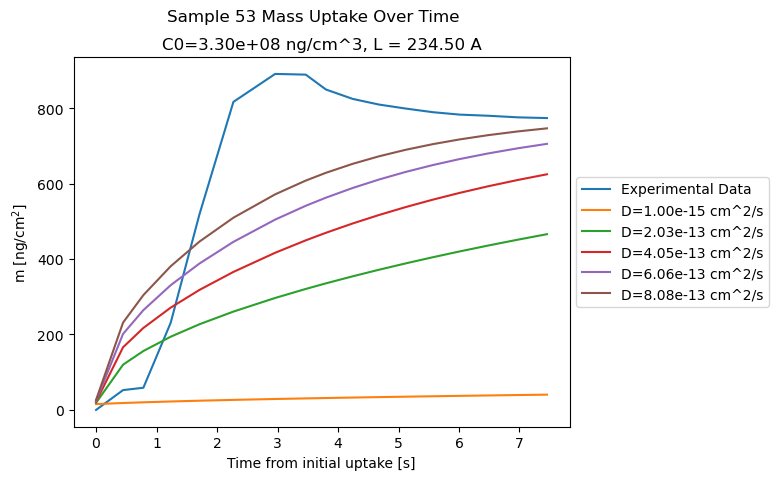

In [45]:
plt.plot(times, m_exp, label='Experimental Data')

for D, uptake in list(m_an.items())[::20]:

    plt.plot(times, uptake, label=f'D={D:.2e} cm^2/s')


plt.xlabel('Time from initial uptake [s]')
plt.ylabel('m [ng/cm$^2$]')

plt.suptitle('Sample 53 Mass Uptake Over Time')
plt.title(f'C0={C0:.2e} ng/cm^3, L = {L_A:.2f} A')

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

## Numerical Solution for Given Boundary Conditions

### Testing with Random ICs

In [17]:
C0 = 5
D = lambda x: np.cos(np.pi*x) + 1.5
k = 0
L = 1
tf = 5



C = num_grid(C0, D, k, L, tf, Nt=1000, Nx=1000, theta=0.55)

In [4]:
C

Array([[5.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.99994135e+00, 9.82373142e+00, 9.65066338e+00, ...,
        8.98373764e-06, 5.98134375e-06, 2.98828127e-06],
       [5.00099134e+00, 1.77714035e-01, 3.48208845e-01, ...,
        1.06720276e-04, 7.10699314e-05, 3.55113407e-05],
       ...,
       [5.00138474e+00, 2.46912813e+00, 3.90385294e+00, ...,
        6.67744651e-02, 4.45174426e-02, 2.22587399e-02],
       [5.00102806e+00, 7.52253008e+00, 6.07866812e+00, ...,
        6.67763948e-02, 4.45188135e-02, 2.22593863e-02],
       [5.00407124e+00, 2.47545648e+00, 3.91058969e+00, ...,
        6.67779669e-02, 4.45197783e-02, 2.22599097e-02]], dtype=float32)

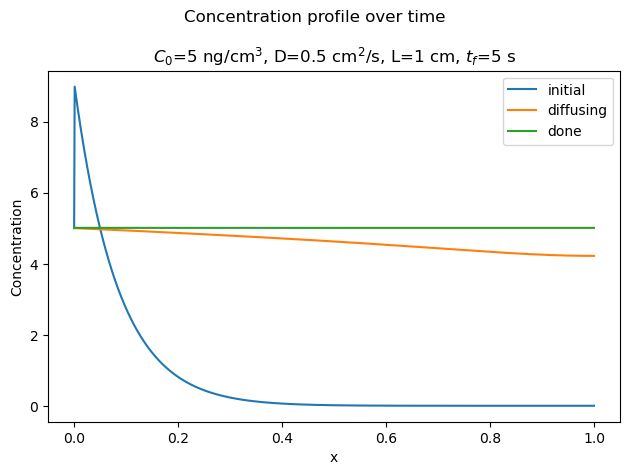

Total Solute:
t=0.00s: 0.7510
t=0.02s: 2.6801
t=0.25s: 4.9889
t=5.00s: 5.0060


In [18]:
L = 1
tf = 1


x = np.linspace(0, L, C.shape[1])
dx = L/C.shape[1]
dt = tf/C.shape[0]

plt.plot(x, C[0], label='initial')
plt.plot(x, C[100], label = 'diffusing')
plt.plot(x, C[-1], label='done')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.suptitle(f"Concentration profile over time")
plt.title("$C_0$=5 ng/cm$^3$, D=0.5 cm$^2$/s, L=1 cm, $t_f$=5 s")
plt.legend()
plt.tight_layout()
plt.show()

print("Total Solute:")
print(f't=0.00s: {np.sum(C[0]*dx):.4f}')
print(f't={20*dt:.2f}s: {np.sum(C[20]*dx):.4f}')
print(f't={250*dt:.2f}s: {np.sum(C[250]*dx):.4f}')
print(f't=5.00s: {np.sum(C[-1]*dx):.4f}')

### More Random Tests

In [9]:
# Sample 53
df = cropped_sample_dfs_first['Sample 53']
df = df[df['Time shifted [s]'] >= 0]

times = jnp.array(df['Time shifted [s]'].values) # [s]
m_exp = jnp.array(df['C1_m [ng/cm^2]'].values)   # [ng/cm^2]

L = float(thicknesses.loc[53, 'Thickness [A]']) # [A]
L *= 1e-8 # [cm]

# Divide final uptake (assuming steady state reached) by the length to get assumed boundary concentration
C0 = m_exp[-1]/L # [ng/cm^3]

# No reaction term
k = 0

# Small N, slight innaccuracy
Nx = 20
Nt = 20

f = lambda x: jnp.ones_like(x)*2e-12

In [16]:
num_uptake_data_15 = num_uptake(C0, f, k, L, times, Nx=50, Nt=50, theta=0.55)

In [11]:
num_uptake_data_alt = accurate_num_uptake(C0, f, k, L, times, Nx=20, Nt=20)
an_uptake_data = an_uptake(C0, f(0), L, times)

  0%|          | 0/17 [00:00<?, ?it/s]c:\Users\willi\Documents\Diffusion-Modeling\utils.py:414: UserWarning: Explicitly requested dtype float64 requested in full is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  C = jnp.full(Nx+1, C0, dtype='float')
100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


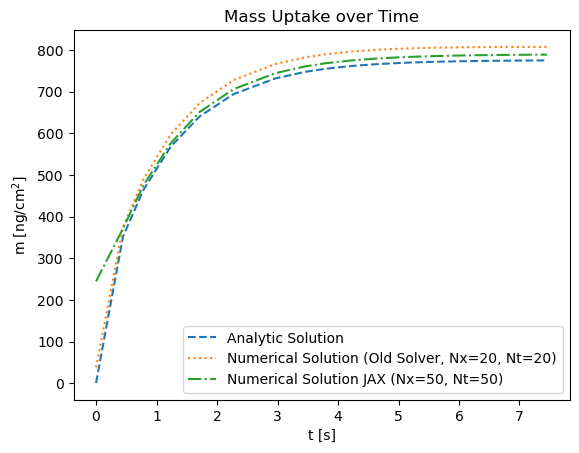

In [17]:
plt.plot(times, an_uptake_data, label='Analytic Solution', linestyle='--')
plt.plot(times, num_uptake_data_alt, label='Numerical Solution (Old Solver, Nx=20, Nt=20)', linestyle=':')
plt.plot(times, num_uptake_data_15, label='Numerical Solution JAX (Nx=50, Nt=50)', linestyle='-.')
plt.xlabel('t [s]')
plt.ylabel('m [ng/cm$^2$]')
plt.title('Mass Uptake over Time')
plt.legend()

### Testing vs. Analytic Soln

In [5]:
# Sample 53 ICs
df = cropped_sample_dfs_first['Sample 53']
df = df[df['Time shifted [s]'] >= 0]

times = df['Time shifted [s]'] # [s]
m_exp = df['C1_m [ng/cm^2]']   # [ng/cm^2]

L = thicknesses.loc[53, 'Thickness [A]'] # [A]
L *= 1e-8 # [cm]

# Divide final uptake (assuming steady state reached) by the length to get assumed boundary concentration
C0 = m_exp.iloc[-1]/L # [ng/cm^3]

# Final time for an_grid
tf = times.iloc[-1]

# No reaction term
k = 0

In [6]:
print(f'C0: {C0:.2f} ng/cm^3')
print(f'L: {L:.2f} cm')
print('Times: ')
for time in times:
    print(f'    {time:.2f} s')


C0: 330021321.96 ng/cm^3
L: 0.00 cm
Times: 
    0.00 s
    0.45 s
    0.78 s
    1.23 s
    1.71 s
    2.27 s
    2.96 s
    3.47 s
    3.80 s
    4.24 s
    4.68 s
    5.12 s
    5.57 s
    6.01 s
    6.48 s
    6.97 s
    7.45 s


### Theta=0.55 Being insanely goated

In [ ]:
f = lambda x:  1e-12 * jnp.ones_like(x) # [cm^2 / s]
D = 1e-12

x = np.linspace(0, L, 501)

C_an = an_grid(C0, D, L, tf)[-1]


# vv Try the below with theta=0.5 (default) for comparison  VV

# Small N, slight innaccuracy
Nx, Nt = 20, 20
C_num_20 = num_grid(C0, f, k, L, tf, Nx=Nx, Nt=Nt, theta=0.55)[-1]
C_num_20 = np.interp(x, np.linspace(0, L, Nx+1), C_num_20)

# Bigger N
Nx, Nt = 500, 500
C_num_500 = num_grid(C0, f, k, L, tf, Nx=Nx, Nt=Nt, theta=0.55)[-1]



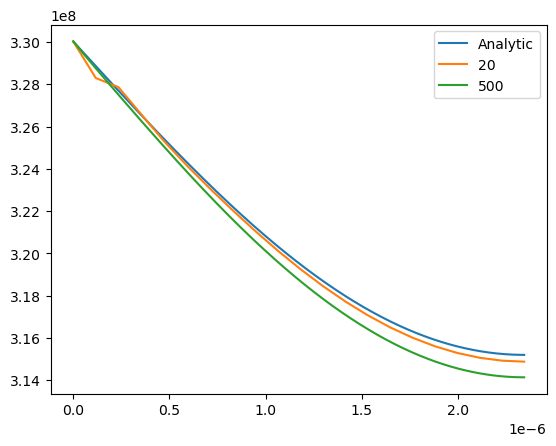

In [21]:
plt.plot(x, C_an, label='Analytic')
plt.plot(x, C_num_20, label='20')
plt.plot(x, C_num_500, label='500')

plt.legend()

## Setting up Manual D(x)

In [ ]:
# Sample 53
df = cropped_sample_dfs_first['Sample 53']
df = df[df['Time shifted [s]'] >= 0]

times = jnp.array(df['Time shifted [s]'].values) # [s]
m_exp = jnp.array(df['C1_m [ng/cm^2]'].values)   # [ng/cm^2]

L = float(thicknesses.loc[53, 'Thickness [A]']) # [A]
L *= 1e-8 # [cm]

# Divide final uptake (assuming steady state reached) by the length to get assumed boundary concentration
C0 = m_exp[-1]/L # [ng/cm^3]

# No reaction term
k = 0


f = lambda x: jnp.ones_like(x)*2e-12

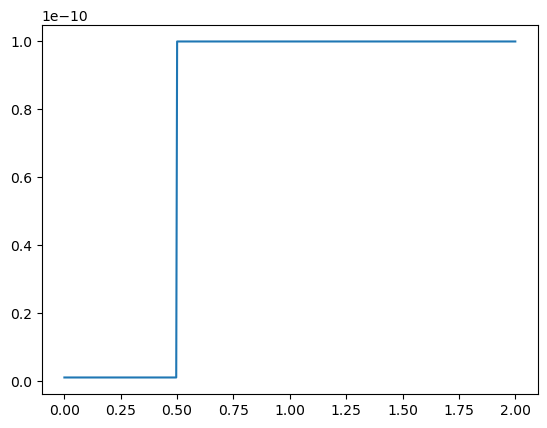

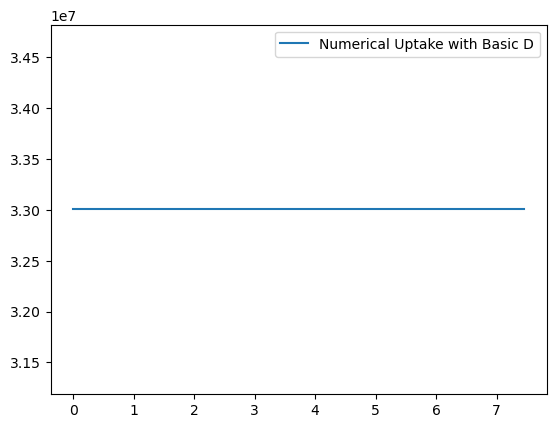

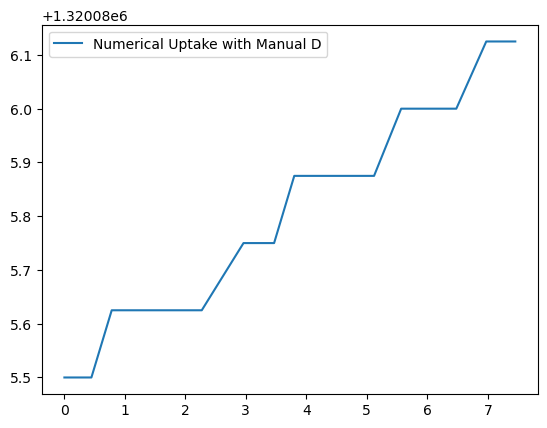

In [22]:
def manual_D(x):
    len_x = len(x)
    len_bar = len_x//4
    len_main = len_x - len_bar
    barrier = np.ones((len_bar,))*1e-12
    body = np.ones((len_main,))*1e-10

    return np.concatenate((barrier, body))
L = 2

x = np.linspace(0, L, 501)

D_manual = manual_D(x)

plt.figure(1)
plt.plot(x, D_manual)


basic_D = lambda x: 1e-12 * jnp.ones_like(x)

m0 = num_uptake(C0, basic_D, k, L, times, Nx=20, Nt=20, theta=0.55)
m = num_uptake(C0, manual_D, k, L, times, Nx=500, Nt=500, theta=0.55)

plt.figure(2)

plt.plot(times, m0, label='Numerical Uptake with Basic D')
plt.legend()

plt.figure(3)
plt.plot(times, m, label='Numerical Uptake with Manual D')


plt.legend()

array([1., 1., 1., 1., 1.])

## Setting up a generic D(x) Spline

### Using Scipy (Doesn't work with Jax)

In [ ]:
def make_spline_sp(weights, L): 
    '''
    Makes a cubic B-spline from the given weights over the interval [0, L].
    Seems to work well with ~10 weights.
    Uses Scipy BSpline, not compatible with Jax
    '''
    k = 3                    
    n = len(weights)

    # clamped knot vector
    t = jnp.concatenate((
        jnp.zeros(k),
        jnp.linspace(0, L, n - k + 1),
        jnp.ones(k) * L
    ))

    spline = BSpline(t, weights, k)
    return spline

### Jax-Friendly Spline

Imported from `utils.py`.

[0.85569877 0.84868638 0.66174755 0.63791968 0.85863842 0.45648743
 0.8148098  0.09019138 0.27751104 0.91837344]


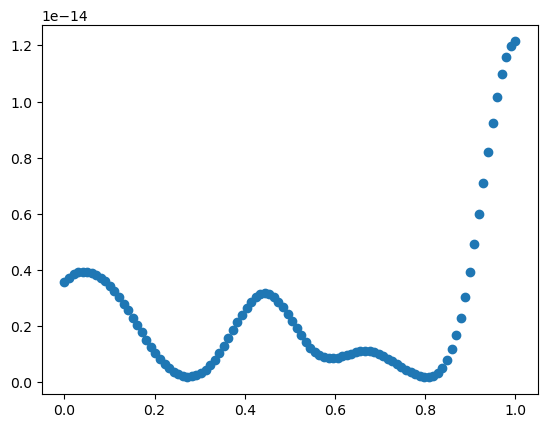

In [16]:
weights = np.random.rand(10)


f = make_spline(weights, L=1, lin_weighting=1e-12, exp_weighting=20)

x = np.linspace(0, 1, 100)

plt.plot(x, f(x), 'o')

print(weights)

[-2.8304616e-14  4.6713187e-13  2.9570297e-13  1.5354592e-13
 -1.2403282e-13  2.1692315e-13 -1.4408790e-12  7.5585989e-13
  5.2140963e-13  9.1017038e-13]


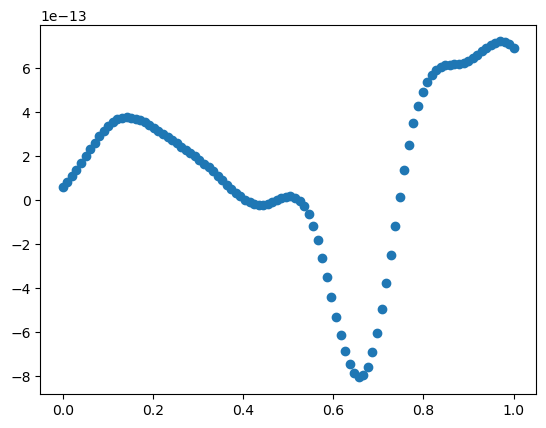

In [87]:
# More accurate numbers

key = jax.random.PRNGKey(42)
weights = jax.random.normal(key, (10,))*1e-12 # Scaled to order of 1e-12 [cm^2/s] diffusion coefficients

f = make_spline(weights, L=1)

x = np.linspace(0, 1, 100)

plt.plot(x, f(x), 'o')

print(weights)

## Numeric Solution Convergence Testing

### Implementation

In [5]:
def test_accuracy(
        solver: Callable,
        Nx_list: Iterable[int],
        Nt_list: Iterable[int],
        C0: float, 
        f: Callable, 
        L: float, 
        tf: float,
        analytic: Optional[Callable] = None,
        ref_factor: int = 16,
    ):
    '''
    Tests the accurary of the numerical solution vs a reference solution over a range of Nx and Nt, as well as a range of given input parameters.
    If no analytic solution is available, the reference solution used is the numeric solution with 
    N values a specified multiple higher than the highest tested value.

    Currently designed for f as function input

    Nx:tf: Lists of inputs to be tested for accuracy and tabulated
    analytic: the analytic solution, if available. Otherwise, equals None.
    ref_factor: Nx_ref = max(Nx)*ref_factor, Nt_ref = max(Nt)*ref_factor, etc.
    '''
    k = 0.0 # Why do I even have this anymore

    Nx_ref = max(Nx_list)*ref_factor
    Nt_ref = max(Nt_list)*ref_factor

    df_columns = ["Nx", "Nt", "C0", "f", "L", "k", "tf", "Error"]
    df_rows = []

    if analytic is not None:
        D = float(f(0))
        ref_soln = analytic(C0, D, L, tf, Nx=Nx_ref, Nt=Nt_ref)
    else: 
        ref_soln = solver(C0, f, k, L, tf , Nx=Nx_ref, Nt=Nt_ref)


    for Nx in tqdm(Nx_list, desc="Calculating errors"):
        for Nt in Nt_list:

            num_soln = solver(C0, f, k, L, tf, Nx=Nx, Nt=Nt)
            x_test_points = np.linspace(0, Nx_ref, Nx+1, dtype=int) # subsamples evenly spaced points along the analytic soln for each point on the num soln.
            t_test_points = np.linspace(0, Nt_ref, Nt, dtype=int) # There is one less point in the time axis due to jax timestep loop behavior
            ref_soln_sampled = ref_soln[np.ix_(t_test_points, x_test_points)] # Gets test points for every time tn
            if ref_soln_sampled.shape != num_soln.shape: 
                raise ValueError(f"Length of the reference and numeric solutions do not match!\nRef: {ref_soln_sampled.shape}\nNum: {num_soln.shape}")
            err = L2norm(ref_soln_sampled, num_soln)                  

            row = [Nx, Nt, C0, f, L, k, tf, err]
            df_rows.append(row)
            
    soln_data = pd.DataFrame(df_rows, columns=df_columns)

    return soln_data

### Testing vs. Analytic, Constant D

In [ ]:
N = [50*2**n for n in range(10)]
Nx = [50]
Nt = N

C0 = 1e9
f = lambda x: 1e-12*np.ones_like(x)
D = 1e-12
L = 2.5e-8
tf = 10


C_num = num_grid(C0, f, 0, L, tf, Nx=Nx[0], Nt=Nt[0])

In [7]:
err_data = test_accuracy(
    num_grid,
    Nx,
    Nt,
    C0,
    f,
    L,
    tf,
    analytic=an_grid,
    ref_factor=2
)

Calculating errors: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


In [8]:
err_data

,Nx,Nt,C0,f,L,k,tf,Error
0,50,50,1.000000e+09,<function <lambda> at 0x000001F03D996660>,2.500000e-08,0.0,10,0.6736539
1,50,100,1.000000e+09,<function <lambda> at 0x000001F03D996660>,2.500000e-08,0.0,10,0.5835076
2,50,200,1.000000e+09,<function <lambda> at 0x000001F03D996660>,2.500000e-08,0.0,10,0.44029346
3,50,400,1.000000e+09,<function <lambda> at 0x000001F03D996660>,2.500000e-08,0.0,10,0.32190603
4,50,800,1.000000e+09,<function <lambda> at 0x000001F03D996660>,2.500000e-08,0.0,10,0.22484316
5,50,1600,1.000000e+09,<function <lambda> at 0x000001F03D996660>,2.500000e-08,0.0,10,0.14880995
6,50,3200,1.000000e+09,<function <lambda> at 0x000001F03D996660>,2.500000e-08,0.0,10,0.09046902
7,50,6400,1.000000e+09,<function <lambda> at 0x000001F03D996660>,2.500000e-08,0.0,10,0.04881984
8,50,12800,1.000000e+09,<function <lambda> at 0x000001F03D996660>,2.500000e-08,0.0,10,0.024415331
9,50,25600,1.000000e+09,<function <lambda> at 0x000001F03D996660>,2.500000e-08,0.0,10,0.0120007135


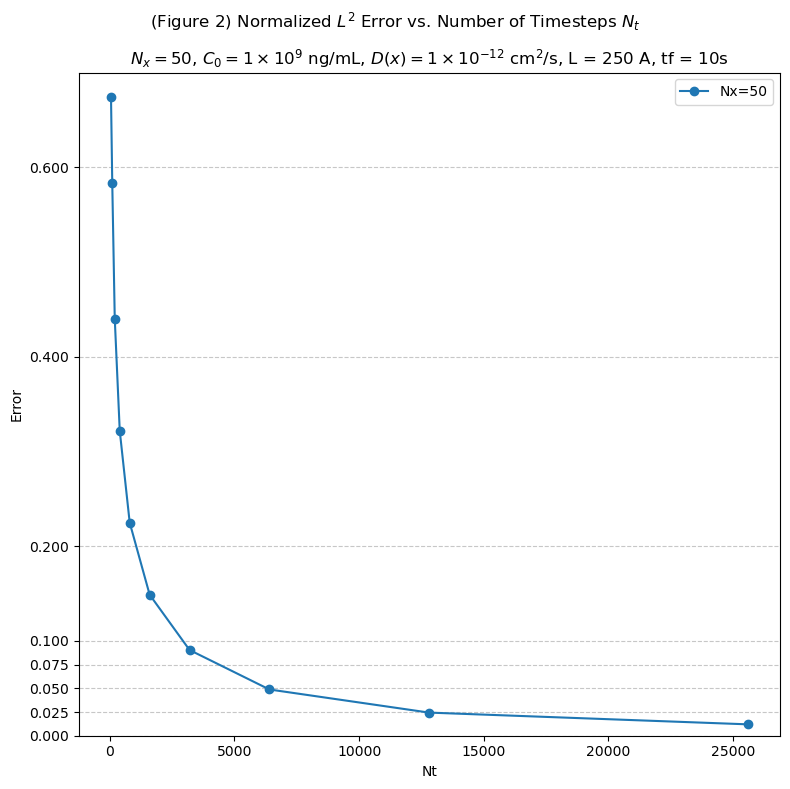

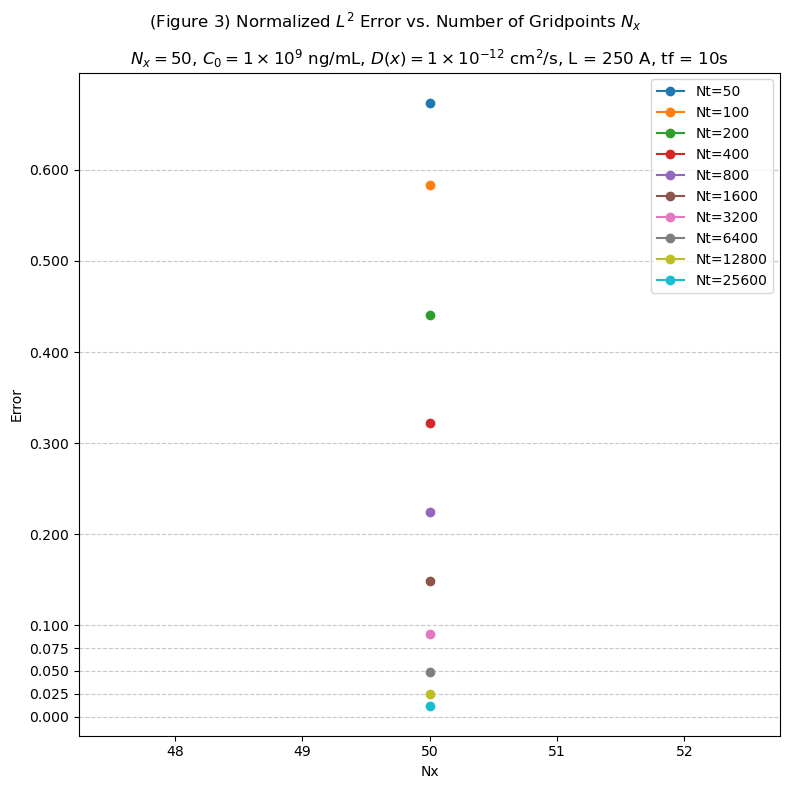

In [ ]:
plt.figure(1, figsize=(8,8))

plt.xlabel('Nt')
plt.ylabel('Error')
plt.suptitle('Normalized $L^2$ Error vs. Number of Timesteps $N_t$')
plt.title("$N_x=50$, $C_0 = 1 \\times 10^9$ ng/mL, $D(x) = 1 \\times 10^{-12}$ cm$^2$/s, L = 250 A, tf = 10s")

for Nx_i in Nx:
    sub_costs = err_data.loc[err_data["Nx"]==Nx_i]
    plt.plot(sub_costs["Nt"], sub_costs["Error"], 'o-', label=f'Nx={Nx_i}')

yticks = np.concatenate([np.linspace(0, 0.1, 5), np.linspace(0.2, 1, 5)])
plt.yticks(yticks)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0,0.7)

plt.legend()
plt.tight_layout()



plt.figure(2, figsize=(8,8))

plt.xlabel('Nx')
plt.ylabel('Error')
plt.suptitle('Normalized $L^2$ Error vs. Number of Gridpoints $N_x$')
plt.title("$N_x=50$, $C_0 = 1 \\times 10^9$ ng/mL, $D(x) = 1 \\times 10^{-12}$ cm$^2$/s, L = 250 A, tf = 10s")

for Nt_i in Nt:
    sub_costs = err_data.loc[err_data["Nt"]==Nt_i]
    plt.plot(sub_costs["Nx"], sub_costs["Error"], 'o-', label=f'Nt={Nt_i}')

yticks = np.concatenate([np.linspace(0, 0.1, 5), np.linspace(0.2, 0.6, 5)])
plt.yticks(yticks)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()
plt.tight_layout()

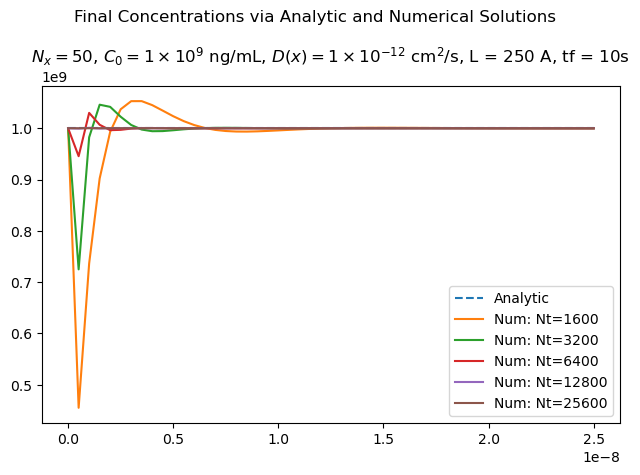

In [16]:
# Plotting the above
x = np.linspace(0, L, Nx[0]+1)
an_soln_final = an_grid(C0, D, L, tf, Nx=Nx[0])[-1]
plt.plot(x, an_soln_final, label='Analytic', linestyle='--')
plt.suptitle('Final Concentrations via Analytic and Numerical Solutions')
plt.title("$N_x=50$, $C_0 = 1 \\times 10^9$ ng/mL, $D(x) = 1 \\times 10^{-12}$ cm$^2$/s, L = 250 A, tf = 10s")

for Nt_i in Nt[5:]:
    num_soln_final = num_grid(C0, f, 0, L, tf, Nx=Nx[0], Nt=Nt_i)[-1]
    plt.plot(x, num_soln_final, label=f'Num: Nt={Nt_i}')

plt.tight_layout()
plt.legend()
    

### Testing vs. Ref., Variable D(x) Random Spline

## Gradient Descent for D(x)

### Import Sample 53 ICs

In [17]:
# Sample 53 ICs
df = cropped_sample_dfs_first['Sample 53']
df = df[df['Time shifted [s]'] >= 0]

times = jnp.array(df['Time shifted [s]'].values) # [s]
m_exp = jnp.array(df['C1_m [ng/cm^2]'].values)   # [ng/cm^2]

L = float(thicknesses.loc[53, 'Thickness [A]']) # [A]
L *= 1e-8 # [cm]

# Divide final uptake (assuming steady state reached) by the length to get assumed boundary concentration
C0 = m_exp[-1]/L # [ng/cm^3]

# Final time for an_grid
tf = times[-1]

# No reaction term
k = 0

### Error Function and Error Gradient

In [25]:
def pack_params(weights, lin_weighting, lin_power, exp_weighting, median):
    params = jnp.concatenate([
        weights,
        lin_weighting,
        lin_power,
        exp_weighting,
        median
    ])
    return params
    
def unpack_params(params, L):
    weights = params[0:10] # (Not including the final point)
    lin_weighting = params[10]
    lin_power = params[11]
    exp_weighting = params[12]
    median = params[13]
    lin_weighting_scaled = lin_weighting*10**lin_power
    
    unpacked_params = {
        'weights': weights,
        'L': L,
        'lin_weighting': lin_weighting_scaled,
        'exp_weighting': exp_weighting,
        'median': median
    }
    return unpacked_params

def error(params):
    '''  
    Makes a differentiable error function for jax.
    Uses many conditions defined above for Sample 53.
    D is defined by the spline made from the input weights.

    HARD CODED:
    - Using Nx=50 and Nt=2800 as determined above, for constant D ~ 1e-12 and tf ~ 10s.
    - Using theta=0.55 based on positive results.

    params: Input vector containing the weights and weighting:

    params[0:9] := weights vector (float values 0<w<10)
    params[10]  := linear weighting (std value 0<lw<9 -> scaled lin weighting = 1e-12)
    params[11]  := linear power (std value = -12 -> scaled lin weighting = 1e-12)
    params[12]  := exponential weighting (std value 1.0)
    params[13]  :=' median' value (std value 0.0)
    '''
    
    weights = params[0:10] # (Not including the final point)
    lin_weighting = params[10]
    lin_power = params[11]
    exp_weighting = params[12]
    median = params[13]
    lin_weighting_scaled = lin_weighting*10**lin_power

    D = make_spline(weights, L, lin_weighting=lin_weighting_scaled, exp_weighting=exp_weighting, median=median)
    
    m_num = num_uptake(C0, D, k, L, times, Nx=50, Nt=12800, theta=0.55) 
    return L2norm(jnp.array(m_num), jnp.array(m_exp))

error_grad = jax.grad(error) # Should return a function that outputs the gradient vector as a function of params

### Manual Gradient Descent

In [26]:
def grad_descent(params, learning_rate=0.1, num_steps=200):
    '''
    Simple gradient descent optimizer.
    Should probably use less steps at least until more optimized.

    Normalizes the learning rate by the gradient magnitude.
    '''
    
    initial_params = params.copy() # Saves for later comparison

    errs = []
    for step in tqdm(range(num_steps), desc='Gradient Descent'):
        grad_vector = error_grad(params)
        delta = learning_rate / jnp.linalg.norm(grad_vector) + 1e-12 # Safety epsilon
        params = params - delta*grad_vector
        if step % 100 == 0:
            err = error(params)
            errs.append(err)
            tqdm.write(f"Step {step}, Error: {err:.6f}")
    return initial_params, params, errs

### Optax Adam Gradient Descent

In [27]:
def optax_gd(params, learning_rate=1e-2, num_steps=1000, check_every=100):

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    initial_params = params.copy() # Saves for later comparison

    errs = []
    for step in tqdm(range(num_steps), desc='Optax Gradient Descent'):
        grad_vector = error_grad(params)
        updates, opt_state = optimizer.update(grad_vector, opt_state)
        params = optax.apply_updates(params, updates)
        if step % check_every == 0:
            err = error(params)
            errs.append(err)
            tqdm.write(f"Step {step}, Error: {err:.6f}")

    return initial_params, params, errs


### Random Initial Weights -> Experimental Data

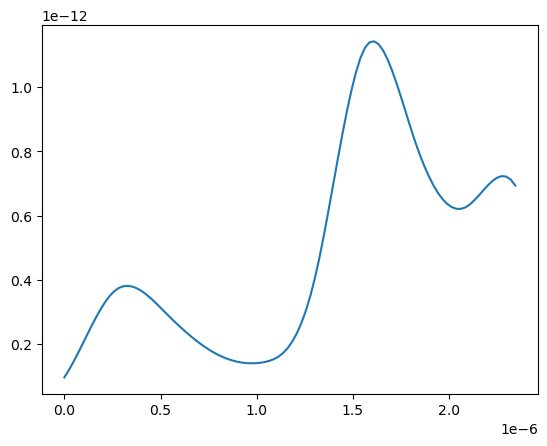

In [23]:
# Weights aught to be a vector of random floats between 0 and 10.

key = jax.random.PRNGKey(42)
weights = jax.random.normal(key, (10,))
weights = np.abs(weights)*10

x = np.linspace(0, L, 100)

f = make_spline(weights, L)

plt.plot(x, f(x))

In [ ]:
initial_params, optimized_params, errs = optax_gd(params, learning_rate=0.1, )

optimized_params

Gradient Descent:   0%|          | 1/1000 [00:01<24:19,  1.46s/it]

Step 0, Error: 0.973633


Gradient Descent:  10%|█         | 101/1000 [02:55<19:32,  1.30s/it]

Step 100, Error: 0.921828


Gradient Descent:  20%|██        | 201/1000 [05:06<18:24,  1.38s/it]

Step 200, Error: 0.905755


Gradient Descent:  30%|███       | 301/1000 [07:18<16:17,  1.40s/it]

Step 300, Error: 0.894812


Gradient Descent:  40%|████      | 401/1000 [09:31<13:44,  1.38s/it]

Step 400, Error: 0.886300


Gradient Descent:  50%|█████     | 501/1000 [11:45<11:28,  1.38s/it]

Step 500, Error: 0.879248


Gradient Descent:  60%|██████    | 601/1000 [13:57<09:04,  1.36s/it]

Step 600, Error: 0.873188


Gradient Descent:  70%|███████   | 701/1000 [16:11<06:50,  1.37s/it]

Step 700, Error: 0.867849


Gradient Descent:  80%|████████  | 801/1000 [18:24<04:34,  1.38s/it]

Step 800, Error: 0.863063


Gradient Descent:  90%|█████████ | 901/1000 [20:36<02:15,  1.37s/it]

Step 900, Error: 0.858714


Gradient Descent: 100%|██████████| 1000/1000 [22:47<00:00,  1.37s/it]


Array([ 2.4795648e-01,  1.7882223e-01,  2.3613170e-02,  9.8305650e-04,
        2.4256592e-06,  4.1235643e-13, -1.4408790e-12,  7.5585989e-13,
        5.2140963e-13,  9.1017038e-13], dtype=float32)

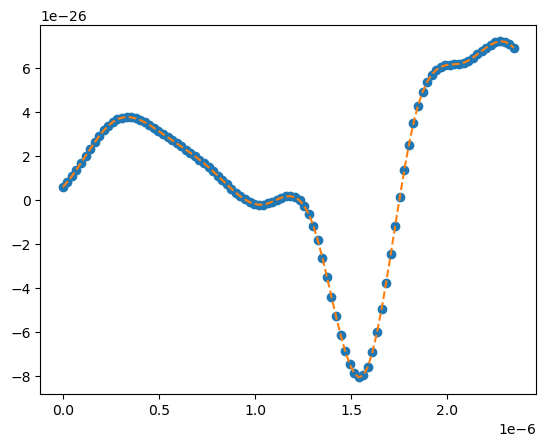

In [17]:
f = make_spline(weights, L)
f0 = make_spline(initial_weights, L)

x = np.linspace(0, L, 100)

plt.plot(x, f(x), 'o', x, f0(x), '--')

In [18]:
D = f

fitted_uptake_data = num_uptake(C0, D, k, L, times, Nx=50, Nt=50)

100%|██████████| 50/50 [00:00<00:00, 1470.35it/s]


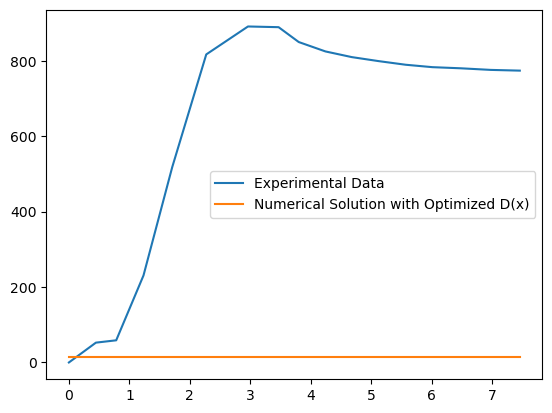

In [19]:
plt.plot(times, m_exp, label='Experimental Data')
plt.plot(times, fitted_uptake_data, label='Numerical Solution with Optimized D(x)')

plt.legend()

In [45]:
# exact test

weights = np.array([0.17868845, 0.01583082, 0.71467524, 0.56208104, 0.66165666, 0.86287856, 0.65813332, 0.61599403, 0.53966636, 0.93575107])
L = 250e-8
C0 = 1e9 #ng/mL

tf = 2

D = make_spline(weights, L=L)

k=0

C_profile = num_grid(C0, D, k, L, tf)

C_profile[-1,:]

array([1.00000000e+09, 9.91363734e+08, 9.82730212e+08, 9.74092783e+08,
       9.65445082e+08, 9.56781006e+08, 9.48095265e+08, 9.39382707e+08,
       9.30638686e+08, 9.21858875e+08, 9.13039454e+08, 9.04177203e+08,
       8.95269152e+08, 8.86312685e+08, 8.77305738e+08, 8.68246820e+08,
       8.59134858e+08, 8.49969218e+08, 8.40749915e+08, 8.31477548e+08,
       8.22153242e+08, 8.12779025e+08, 8.03357331e+08, 7.93891456e+08,
       7.84385319e+08, 7.74843479e+08, 7.65271312e+08, 7.55674932e+08,
       7.46061189e+08, 7.36437642e+08, 7.26812462e+08, 7.17194641e+08,
       7.07593697e+08, 6.98019697e+08, 6.88483109e+08, 6.78994877e+08,
       6.69566254e+08, 6.60208695e+08, 6.50933900e+08, 6.41753336e+08,
       6.32678478e+08, 6.23720426e+08, 6.14889922e+08, 6.06197313e+08,
       5.97652440e+08, 5.89264423e+08, 5.81041648e+08, 5.72991647e+08,
       5.65121262e+08, 5.57436332e+08, 5.49941740e+08, 5.42641501e+08,
       5.35538719e+08, 5.28635558e+08, 5.21933408e+08, 5.15432835e+08,
      

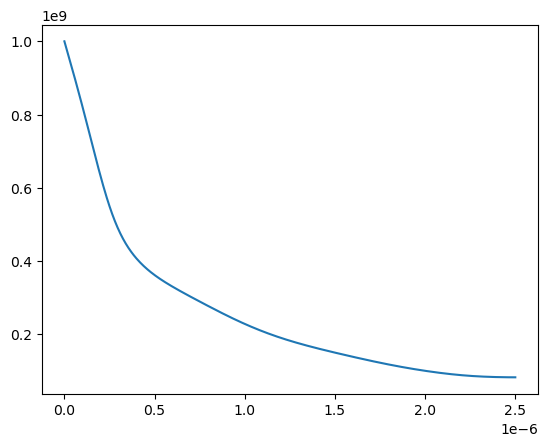

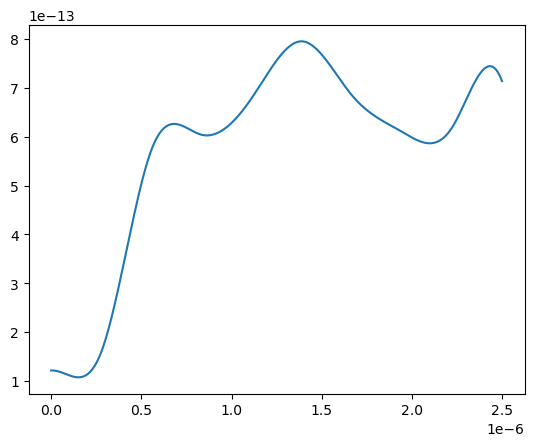

In [47]:
x = np.linspace(0, L, 501)

plt.plot(x, C_profile[-1,:])

plt.figure(2)

plt.plot(x, D(x))

### Random initial Weights -> Constant-D Artificial Data

  0%|          | 0/17 [00:00<?, ?it/s]c:\Users\willi\Documents\Diffusion-Modeling\utils.py:414: UserWarning: Explicitly requested dtype float64 requested in full is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  C = jnp.full(Nx+1, C0, dtype='float')
100%|██████████| 17/17 [00:02<00:00,  6.74it/s]


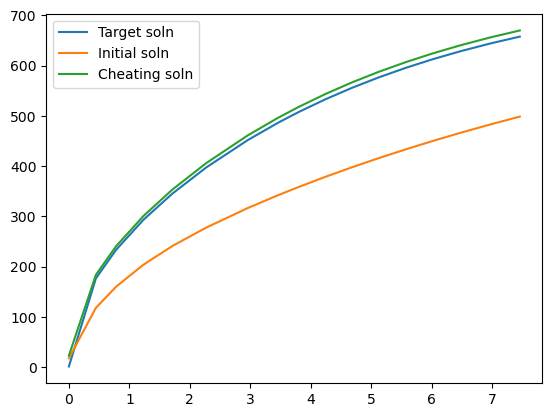

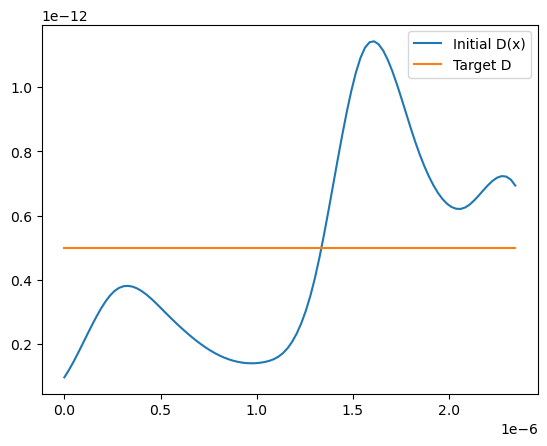

In [33]:
fake_D = 0.5e-12
fake_uptake = an_uptake(C0, fake_D, L, times)

# Initial Weights
key = jax.random.PRNGKey(42)
weights = jax.random.normal(key, (10,))
weights = np.abs(weights)*10
# Initial weighting
lin_weighting = jnp.array([1.0])
lin_power = jnp.array([-12])
exp_weighting = jnp.array([1.0])
median = jnp.array([0.0])

params = pack_params(
    weights,
    lin_weighting,
    lin_power,
    exp_weighting,
    median
)

lin_weighting_input = float(lin_weighting[0])*10**float(lin_power[0])
exp_weighting_input = float(exp_weighting[0])
median_input = float(median[0])
initial_D = make_spline(weights, L, lin_weighting=lin_weighting_input, exp_weighting=exp_weighting_input, median=median_input)
cheating_D = lambda x: fake_D*jnp.ones_like(x)
initial_num_uptake = num_uptake(C0, initial_D, 0, L, times, Nx=50, Nt=2800, theta=0.55)
cheating_num_uptake = num_uptake(C0, cheating_D, 0, L, times, Nx=50, Nt=2800, theta=0.55)

plt.figure(1)
plt.plot(times, fake_uptake, label='Target soln')
plt.plot(times, initial_num_uptake, label='Initial soln')
plt.plot(times, cheating_num_uptake, label='Cheating soln')
plt.legend()

plt.figure(2)
f = make_spline(weights, L)
x = np.linspace(0, L, 100)
plt.plot(x, f(x), label='Initial D(x)')
plt.plot(x, fake_D*np.ones_like(x), label='Target D')
plt.legend()

In [34]:
# initial_params, optimized_params, errs = grad_descent(params)

initial_params, optimized_params, errs = optax_gd(params, learning_rate=1e-5, num_steps=100, check_every=100)

Optax Gradient Descent:   1%|          | 1/100 [00:01<01:57,  1.19s/it]

Step 0, Error: 0.647524


Optax Gradient Descent: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


In [35]:
for i, f in zip(initial_params, optimized_params): 
    print(f'{i:.6f},  {f:.6f}')

0.283046,  0.283106
4.671319,  4.671377
2.957030,  2.957089
1.535459,  1.535519
1.240328,  1.240388
2.169231,  2.169291
14.408790,  14.408844
7.558599,  7.558658
5.214096,  5.214155
9.101704,  9.101758
1.000000,  1.000060
-12.000000,  -11.999946
1.000000,  1.000060
0.000000,  0.000060


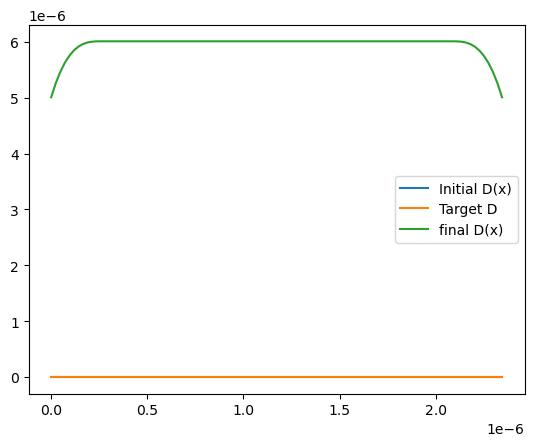

In [ ]:
f0 = make_spline(**unpack_params(initial_params, L))
f = make_spline(**unpack_params(optimized_params, L))
x = np.linspace(0, L, 100)


plt.figure(1)
plt.plot(x, f0(x), label='Initial D(x)')
plt.plot(x, fake_D*np.ones_like(x), label='Target D')
plt.plot(x, f(x), label='final D(x)')
plt.legend()